In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData, check_fluxbalance, alpha_HS04
from mhsflex.field3d import Field3dData, calculate_magfield, j3d, lf3d
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

import mhsflex.fluxbalance

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav

from msat.pyvis.fieldline3d import fieldline3d


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)
c5 = (1.000, 0.000, 0.773)


c6 = (1.000, 0.780, 0.000)
c7 = (0.443, 1.000, 0.855)
c8 = (0.996, 1.000, 0.000)

c9 = (0.671, 0.714, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

data_bz = data["b2dz5"]
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z = 0.04  # Convert pixelsize from km into Mm
pixelsize_x = 0.04
pixelsize_y = 0.04

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax = nresol_x * pixelsize_x
ymax = nresol_y * pixelsize_y

nresol_z = 50

zmax = nresol_z * pixelsize_z

z0 = zmax

nf_max = min(nresol_x, nresol_y)

print("xmax, ymax, zmax", xmax, ymax, zmax)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x)
print("pixelsize_y", pixelsize_y)
print("pixelsize_z", pixelsize_z)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 29 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [4]:
print(data_bz.min())
print(data_bz.max())

-1792.2522
446.3689


In [3]:
x_arr = np.arange(nresol_x) * xmax / (nresol_x - 1)
y_arr = np.arange(nresol_y) * ymax / (nresol_y - 1)
z_arr = np.arange(nresol_z) * zmax / (nresol_z - 1)
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [4]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

print(nresol_x)
print(nresol_y)
print(nresol_z)
print(nf_max)
print(pixelsize_x, pixelsize_y, pixelsize_z)
print(x_arr)
print(y_arr)
print(z_arr)

80
80
50
80
0.04 0.04 0.04
[0.         0.04050633 0.08101266 0.12151899 0.16202532 0.20253165
 0.24303797 0.2835443  0.32405063 0.36455696 0.40506329 0.44556962
 0.48607595 0.52658228 0.56708861 0.60759494 0.64810127 0.68860759
 0.72911392 0.76962025 0.81012658 0.85063291 0.89113924 0.93164557
 0.9721519  1.01265823 1.05316456 1.09367089 1.13417722 1.17468354
 1.21518987 1.2556962  1.29620253 1.33670886 1.37721519 1.41772152
 1.45822785 1.49873418 1.53924051 1.57974684 1.62025316 1.66075949
 1.70126582 1.74177215 1.78227848 1.82278481 1.86329114 1.90379747
 1.9443038  1.98481013 2.02531646 2.06582278 2.10632911 2.14683544
 2.18734177 2.2278481  2.26835443 2.30886076 2.34936709 2.38987342
 2.43037975 2.47088608 2.51139241 2.55189873 2.59240506 2.63291139
 2.67341772 2.71392405 2.75443038 2.79493671 2.83544304 2.87594937
 2.9164557  2.95696203 2.99746835 3.03797468 3.07848101 3.11898734
 3.15949367 3.2       ]
[0.         0.04050633 0.08101266 0.12151899 0.16202532 0.20253165
 0.24303797

# All fields calucalated here are without Seehafer as this was not used by ISSI Team to balance flux through boundary as BC is almost naturally flusbalanced

In [593]:
check_fluxbalance(data2d)

-2.996346e-08

## Field lines are shown for three different cases: 

(1) Low (1991) solution coded by L Nadol with a and alpha chosen as ISSI Reference model, kappa chosen to visually fit to ISSI Reference field  <br>
(2) Asymptotic N+W(2019) solution coded by L Nadol with parameters calculated from (1)  <br>
(3) ISSI Reference model // Low (1991) solution coded by T Wiegelmann / provided by X Zhu

In [6]:
L_X = 3.2
print("Flux-balanced if below 10% --", check_fluxbalance(data2d))
print(
    "Alpha calucated with Sakurai formula --",
    alpha_HS04(data_bx, data_by, data_bz) * nresol_x / L_X,
)

Flux-balanced if below 10% -- -2.996346e-08
Alpha calucated with Sakurai formula -- -0.946507416665554


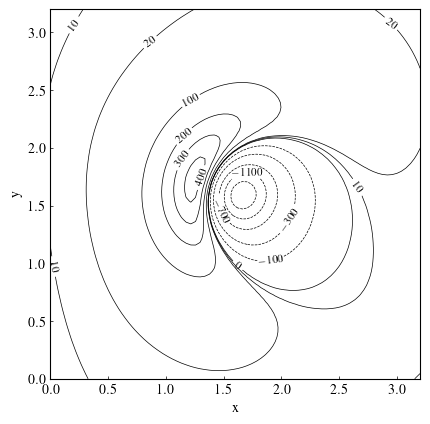

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-1500, -1100, -700, -300, -100, 0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [7]:
alpha = alpha_HS04(data_bx, data_by, data_bz) * (nresol_x-1) / L_X

length_scale_x = nresol_x * pixelsize_x
length_scale_y = nresol_y * pixelsize_y

length_scale_x_norm = length_scale_x
length_scale_y_norm = length_scale_y

kx_arr = np.arange(nf_max) * 2.0 * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * 2.0 * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi * 2.0 / length_scale_x_norm) ** 2 + (
    np.pi * 2.0 / length_scale_y_norm
) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

amax = limit.min()

print(amax)

0.386699330643024


In [8]:
KAPPA_X = 0.02
kappa = KAPPA_X/L_X
print(kappa)

0.0062499999999999995


In [551]:
alpha

-0.9346760739572346

# Meine eigene Low Lösung

In [517]:
# a = amax / 5

# data3d = mhsflex.fluxbalance.calculate_magfield(data2d, a, 1.0, alpha, z0, z0 * 0.1)

kappa = 0.4
a = 0.5
alpha = -0.9346760739572346
data3d = mhsflex.fluxbalance.calculate_magfield(data2d, a, 1.0, alpha, z0, kappa, asymptotic=False, tanh=False)

<built-in method min of numpy.ndarray object at 0x17f7d3f30>


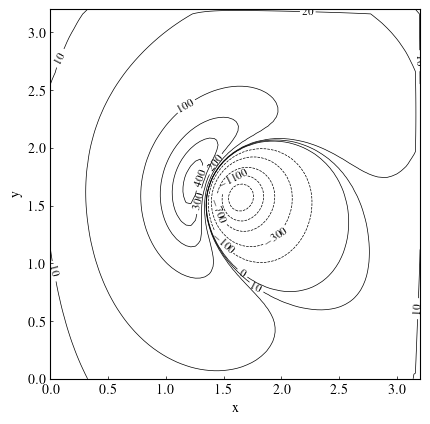

In [143]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data3d.field[:, :, 0, 2],
    levels=np.array((-1500, -1100, -700, -300, -100, 0, 10, 20, 100, 200, 300, 400)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [290]:
sinks = data3d.field[:, :, 0,2].copy()
sources = data3d.field[:, :, 0,2].copy()

maxmask = sources < sources.max() * 0.4
sources[maxmask != 0] = 0

minmask = sinks < sinks.min() * 0.4
sinks[minmask == 0] = 0

[None, None, None, None, None, None]

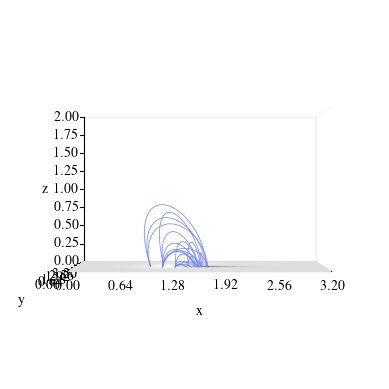

In [573]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
ax.contourf(
    x_grid,
    y_grid,
    data3d.field[:, :, 0,2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))  # type : ignore # (xmax, ymax, 2 * data.z0)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore

ax.xaxis.pane.fill = False  # type : ignore
ax.yaxis.pane.fill = False  # type : ignore
ax.zaxis.pane.fill = False  # type : ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type : ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type : ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type : ignore

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

for ix in range(0, data3d.field.shape[1], int(data3d.field.shape[1] / 20)):
        for iy in range(0, data3d.field.shape[0], int(data3d.field.shape[0] / 20)):
            if sources[iy, ix] != 0 : #or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

# x_0 = 0.0
# y_0 = 0.0
# dx = xmax / 10
# dy = ymax / 10

# nlinesmaxx = int(np.floor(xmax / dx))
# nlinesmaxy = int(np.floor(ymax / dy))

# for ilinesx in range(0, nlinesmaxx):
#         for ilinesy in range(0, nlinesmaxy):
#             x_start = x_0 + dx * ilinesx
#             y_start = y_0 + dy * ilinesy
            
                if data3d.field[int(y_start), int(x_start), 0,2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    data3d.field,
                    y_arr,
                    x_arr,
                    data3d.z,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                if np.isclose(fieldline[:, 2][-1], 0.0) and np.isclose(
                    fieldline[:, 2][0], 0.0
                ):
                    # Need to give row direction first/ Y, then column direction/ X
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )
                else:
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )  # 2 * data.z0  # FOR ZOOM

ax.view_init(0, -90)  # type: ignore

ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))


[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

# N+W (2019) Asymptotische Lösung

In [9]:
from mhsflex.switch import f, f_low

kappa = 0.4
a = 0.5
z0 = 2.0

f_exp = f_low(z_arr, a, kappa)

deltaz = 0.2

b = (np.exp(-kappa * z0) - 1) / (np.exp(-kappa * z0) * np.tanh(-z0 / deltaz))
aN = a / (1 - b * np.tanh(-z0 / deltaz))

f_tanh = f(z_arr, z0, deltaz, aN, b)

print(aN, b)

0.2246644820586108 1.225540933544524


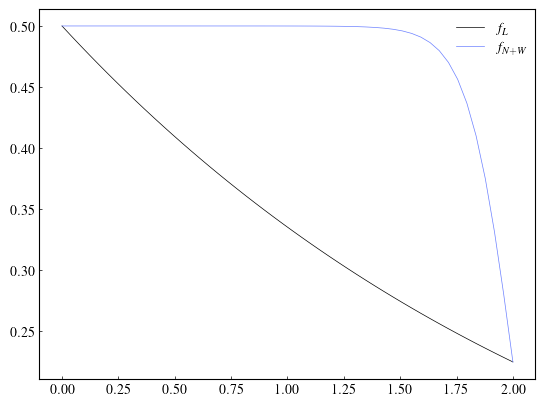

In [591]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    f_exp,
    label=r"$f_L$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
ax1.plot(
    z_arr,
    f_tanh,
    label=r"$f_{N+W}$",
    linewidth=0.5,
    color=c2,
    linestyle="solid",
)
plt.legend(frameon=False)
# ax1.set_xlabel("z")
ax1.tick_params(direction="in", length=2, width=0.5)
# ax2.tick_params(direction="in", length=2, width=0.5)
plt.show()


In [10]:
alpha = -0.9346760739572346
data3d = mhsflex.fluxbalance.calculate_magfield(data2d, aN, b, alpha, z0, deltaz)

<built-in method min of numpy.ndarray object at 0x15b2e8270>


[None, None, None, None, None, None]

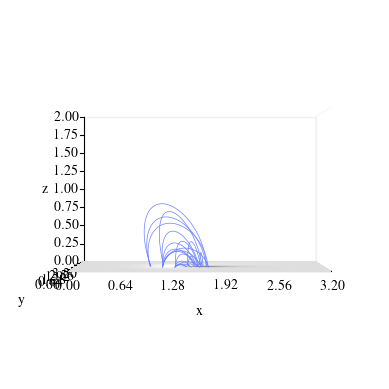

In [592]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
ax.contourf(
    x_grid,
    y_grid,
    data3d.field[:, :, 0,2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))  # type : ignore # (xmax, ymax, 2 * data.z0)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore

ax.xaxis.pane.fill = False  # type : ignore
ax.yaxis.pane.fill = False  # type : ignore
ax.zaxis.pane.fill = False  # type : ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type : ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type : ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type : ignore

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

for ix in range(0, data3d.field.shape[1], int(data3d.field.shape[1] / 20)):
        for iy in range(0, data3d.field.shape[0], int(data3d.field.shape[0] / 20)):
            
            if sources[iy, ix] != 0: # or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

# x_0 = 0.0
# y_0 = 0.0
# dx = xmax / 10
# dy = ymax / 10

# nlinesmaxx = int(np.floor(xmax / dx))
# nlinesmaxy = int(np.floor(ymax / dy))

# for ilinesx in range(0, nlinesmaxx):
#         for ilinesy in range(0, nlinesmaxy):
#             x_start = x_0 + dx * ilinesx
#             y_start = y_0 + dy * ilinesy
            
                if data3d.field[int(y_start), int(x_start), 0,2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    data3d.field,
                    y_arr,
                    x_arr,
                    data3d.z,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                ax.plot(
                    fieldline[:, 1],
                    fieldline[:, 0],
                    fieldline[:, 2],
                    color=c2,
                    linewidth=0.5,
                    zorder=4000,
                )

ax.view_init(0, -90)  # type: ignore

ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))


[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

# Plot ISSI Semi-analytical Low and Lou BC with Low extrapolation without using Seehafer

In [15]:
path3dref = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
data3dref = readsav(path3dref, python_dict=True, verbose=True)

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

presref = data3dref["p3d"] * 10**-1
denref = data3dref["d3d"] * 10**3

issi_bx = np.zeros((nresol_y, nresol_x, nresol_z))
issi_by = np.zeros_like(issi_bx)
issi_bz = np.zeros_like(issi_bx)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_ref = np.zeros((nresol_y, nresol_x, nresol_z, 3))

B_ref[:, :, :, 0] = issi_by[:,:,:]
B_ref[:, :, :, 1] = issi_bx[:,:,:]
B_ref[:, :, :, 2] = issi_bz[:,:,:]

--------------------------------------------------
Date: Tue Sep  6 15:11:11 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 8 are of type VARIABLE
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


[None, None, None, None, None, None]

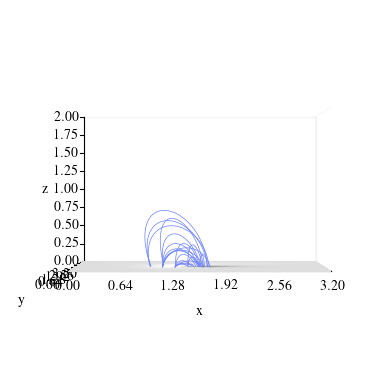

In [571]:
fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
ax.contourf(
    x_grid,
    y_grid,
    B_ref[:, :, 0,2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))  # type : ignore # (xmax, ymax, 2 * data.z0)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore

ax.xaxis.pane.fill = False  # type : ignore
ax.yaxis.pane.fill = False  # type : ignore
ax.zaxis.pane.fill = False  # type : ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type : ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type : ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type : ignore

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

for ix in range(0, B_ref.shape[1], int(B_ref.shape[1] / 20)):
        for iy in range(0, B_ref.shape[0], int(B_ref.shape[0] / 20)):
            if sources[iy, ix] != 0: # or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

# x_0 = 0.0
# y_0 = 0.0
# dx = xmax / 10
# dy = ymax / 10

# nlinesmaxx = int(np.floor(xmax / dx))
# nlinesmaxy = int(np.floor(ymax / dy))

# for ilinesx in range(0, nlinesmaxx):
#         for ilinesy in range(0, nlinesmaxy):
            
#             x_start = x_0 + dx * ilinesx
#             y_start = y_0 + dy * ilinesy
                if B_ref[int(y_start), int(x_start), 0,2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    B_ref,
                    y_arr,
                    x_arr,
                    data3d.z,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                if np.isclose(fieldline[:, 2][-1], 0.0) and np.isclose(
                    fieldline[:, 2][0], 0.0
                ):
                    # Need to give row direction first/ Y, then column direction/ X
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )
                else:
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )  # 2 * data.z0  # FOR ZOOM

ax.view_init(0, -90)  # type: ignore

ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax/ 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))

[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

In [442]:
print(np.unravel_index(data3d.field[:, :, 0,2].argmax(), B_ref[:, :, 0, 2].shape))
print(data3d.field[:, :, 0,2].max())

print(np.unravel_index(B_ref[:, :, 0,2].argmax(), B_ref[:, :, 0, 2].shape))
print(B_ref[:, :, 0,2].max())

print(np.unravel_index(abs(B_ref[:, :, 0,2]-data3d.field[:, :, 0,2]).argmax(), B_ref[:, :, 0, 2].shape))

(42, 30)
445.0053674787617
(43, 31)
446.368896484375
(36, 37)


In [449]:
abs(B_ref[:, :, 0,2]-data3d.field[:, :, 0,2]).max() / abs(data3d.field[36, 37, 0,2])

0.17935199123134712

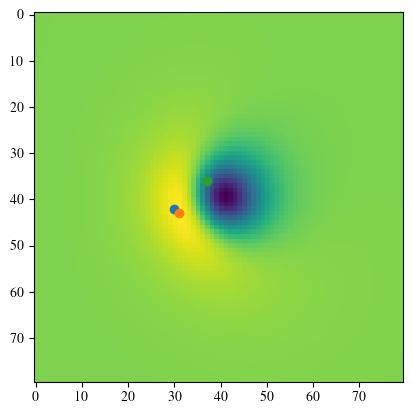

In [451]:
plt.imshow(data3d.bz)
plt.scatter(30, 42)
plt.scatter(31, 43)
plt.scatter(37, 36)


# Verlgeich der Felder sollte hier folgen, aber Code noch nicht angepasst, nur rein kopiert

In [ ]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy

print(VecCorr(B_ref, B_rec))
print(CauSchw(B_ref, B_rec))
print(NormErr(B_ref, B_rec))
print(MeanErr(B_ref, B_rec))
print(MagEnergy(B_ref, B_rec))

print(VecCorr(B_ref, B_ref))
print(CauSchw(B_ref, B_ref))
print(NormErr(B_ref, B_ref))
print(MeanErr(B_ref, B_ref))
print(MagEnergy(B_ref, B_ref))

In [13]:
temps = np.array([6000.0, 5500.0, 10000.0])
heights = np.array([0.0, z0 / 4, z0])

from mhsflex.field3d import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)

backtemp = btemp_linear(data3d, heights, temps)
backpres = bpressure_linear(data3d, heights, temps)
backden = bdensity_linear(data3d, heights, temps)

In [11]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)

RHO0 = 9.0 * 10**-4

P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data2d.bz.max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

In [19]:
maxcoord = np.unravel_index(
    np.argmax(data3d.bz, axis=None),
    data3d.bz.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

In [18]:
plt.plot(
    z_arr,
    fpres[0, 0, :],
    linewidth=0.3,
    color=c4,
    label="Recreated pressure",
)
plt.plot(
    z_arr,
    presref[:, 0, 0],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="Reference pressure",
)
for ix in range(1, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fpres[iy, ix, :],
            linewidth=0.3,
            color=c4,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            presref[:, iy, ix],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
#plotname = folder + "/fpres_comp.png"
#plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
plt.plot(
    z_arr,
    fden[0, 0, :],
    linewidth=0.3,
    color=c4,
    label="Recreated density",
)
plt.plot(
    z_arr,
    denref[:, 0, 0],
    linewidth=0.3,
    color=c2,
    # linestyle="dashed",
    label="Reference density",
)
for ix in range(0, nresol_x, 5):
    for iy in range(4, nresol_y, 5):
        plt.plot(
            z_arr,
            fden[iy, ix, :],
            linewidth=0.3,
            color=c4,  # alpha=0.04
        )
        plt.plot(
            z_arr,
            denref[:, iy, ix],
            linewidth=0.3,
            color=c2,
            # linestyle="dashed",
            # alpha=0.04,
        )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
from mhsflex.metrics import pearson_corr_coeff_issi

pearson_corr_coeff_issi(presref, denref, data3d, heights, temps)